##  Scheduling On Computer Clusters Using Policy Gradient

In [105]:
import copy
import logging.config
import math
import random
from typing import Any, Dict, List, Tuple
import numpy as np
import pkg_resources
from torch import nn
import torch
import copy
import numpy as np
from torch import nn
from torch import optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

Define global parameters

In [116]:
random_seed = 92009
random_batches = False # set to False to train on the same set of jobs
number_of_cores_per_node = 64
number_of_jobs_to_consider = 8 # number of jobs off the front of the queue the network considers
number_of_cores = number_of_cores_per_node
number_of_jobs_per_epsisode = 16
max_job_time = 16 # max timesteps for random job generation
max_job_cores = 8 # max number of cores fro random job generation
discount_gamma = 0.99 # for discounted cummulative reward
max_episode_length = 5000 # stop episode when policy net diverged.
num_batches = 5 # number of episodes before gradient descent
early_stopping = False

In [73]:
class Action:
    def __init__(self, job_index, node_index):
        self.job_index = job_index
        self.node_index = node_index
    def __str__(self):
        return str((self.job_index, self.node_index))
        
class Job:
    def __init__(self, num_cores, num_timesteps, id, priority=0):
        self.num_cores = num_cores
        self.num_timesteps = num_timesteps
        self.id = id
        self.priority = priority

    def __str__(self):
        return str((self.num_cores, self.num_timesteps, self.id, self.priority))
        
class Node:
    def __init__(self, num_cores):
        self.num_cores = num_cores # total number of cores
        self.num_avail_cores = num_cores # current available cores

        # keep track of how long cores are occupied for.
        # (for illustration purposes only, in reality we don't really
        # care which cores are occupied, because they're all the same
        self.core_status = [0] * num_cores
        self.core_job_id = [0] * num_cores

    def schedule(self, job: Job) -> bool:
        """
        Schedule a job on this node.
        Return True if there are enough resources to schedule this job immediately.
        Return False of there are not enough resources.
        Don't schedule a job unless it can be exceuted immediately.
        (This way, we don't have to keep track of per-node queue).
        """
        if self.num_avail_cores < job.num_cores:
            return False

        # Find the available cores
        num_cores_found = 0

        for i in range(self.num_cores):
            if self.core_status[i] == 0:
                # available

                self.core_status[i] = job.num_timesteps
                self.core_job_id[i] = job.id
                
                self.num_avail_cores -= 1
                num_cores_found += 1
                if num_cores_found >= job.num_cores:
                    # found all the cores needed, we're done
                    break
 
        return True
    
    def can_take_job(self, job):
        if self.num_avail_cores < job.num_cores:
            return False
        return True

    def step(self):
        """ Take a step in time. Return list of job IDs finished."""
        finished_jobs = []
        
        for i in range(self.num_cores):
            if self.core_status[i] != 0:
                # core busy
                self.core_status[i] -= 1
                if self.core_status[i] == 0:
                    # no longer busy
                    self.num_avail_cores += 1
                    job_id = self.core_job_id[i]
                    self.core_job_id[i] = 0
                    if not job_id in finished_jobs:
                        finished_jobs.append(job_id)
            
        return finished_jobs

    def __str__(self):
        return 'Number of cores: ' + str(self.num_cores) + '\n' +\
               'Number available: ' + str(self.num_avail_cores) + '\n' +\
               'status: ' + \
               str(self.core_status) + '\n' + \
               'jobs: ' + str(self.core_job_id)

class ClusterEnv():

    def __init__(self) -> None:
        self.number_of_nodes = 1
        self.number_of_cores_per_node = number_of_cores_per_node
        self.nodes = []
        for _ in range(self.number_of_nodes):
            self.nodes.append(Node(self.number_of_cores_per_node))
        self.queue = []
        self.next_job_id = 1

        # Maybe we want to minimize this. Use as loss?
        self.cumulative_wait_time = 0

        # If off-line training, generate list of jobs up-front
        self.queue = self._generate_off_line_jobs()

    def _generate_off_line_jobs(self):
        """
        For off-line scheduling, all jobs arrive at t=0.
        game continues until all jobs are scheduled.
        This function populates the queue at t=0
        """
        global random_seed
        random.seed(random_seed)
        
        global number_of_jobs_per_epsisode
        global max_job_time
        global max_job_cores

        queue = []

        for i in range(1, number_of_jobs_per_epsisode+1):
            num_cores = random.randrange(1, max_job_cores + 1)
            num_time = random.randrange(1, max_job_time + 1)
            queue.append(Job(num_cores, num_time, i))
        return queue

    def get_job_arrivals(self):
        """
        Return a set of jobs to arrive at timestep.
        If running in off-line mode (no job arrivals after t=0),
        then just return empty list.
        """
        return []

    def step(self):
        """
        One timestep in environment
        """
        # take timestep
        total_finished_jobs = 0
        for node in self.nodes:
            finished_jobs = node.step()
            total_finished_jobs += len(finished_jobs)
        self.cumulative_wait_time += len(self.queue)

        # Calculate reward (Not actually used)
        reward = total_finished_jobs
        
        # Get new arrivals
        new_jobs = self.get_job_arrivals()
        for job in new_jobs:
            self.queue.append(job)

        #increment priority
        for job in self.queue:
            job.priority += 1

        # Game over when queue is empty
        if len(self.queue) == 0:
            game_over = True
        else:
            game_over = False

        if early_stopping:
            if len(self.queue) < number_of_jobs_to_consider:
                game_over = True

        # Just return reward for now, because our system is fully transparent
        # i.e., the Agent has perfect knowledge of environment state.
        # return ob, reward, episode_over, debug_info
        return None, reward, game_over, {}

    def take_action(self, action):
        """
        Take action. Rreturn whether or not action was successfully taken.
        """
        if action is None:
            return False
        
        try:
            job = self.queue[action.job_index]
            if self.nodes[action.node_index].schedule(job):
                # only remove from queue if scheduled successfully
                self.queue.pop(action.job_index)
                return True
            return False
        except:
            return False # either job index out of range or node index out of range

    def fast_forward(self):
        """
        fast forward simulation until a job will fit.
        """
        num_timesteps = 0
        
        while True:
            fast_forward = True
            for node in self.nodes:
                for job in self.queue[:number_of_jobs_to_consider]:
                    if (node.can_take_job(job)):
                        fast_forward = False
            if len(self.queue) == 0:
                break

            if fast_forward:
                num_timesteps += 1
                total_finished_jobs = 0
                for node in self.nodes:
                    finished_jobs = node.step()
                    total_finished_jobs += len(finished_jobs)
                self.cumulative_wait_time += len(self.queue)
                
            else:
                break

        return num_timesteps
        
    def reset(self):
        """
        Does nothing for now.
        """
        pass

    def __str__(self):
        return_str = 'Length of queue: ' + str(len(self.queue))
##        return_str = 'Queue: \n'
##        for job in self.queue:
##            return_str += str(job)
##            return_str += '\n'
        for node in self.nodes:
            return_str += str(node)
            return_str += '\n'
        return_str += 'loss: ' + str(self.cumulative_wait_time)
        return return_str

    def _get_state(self) -> List[int]:
        """Get the observation."""
        pass

In [74]:
class MLP(nn.Module):

    def __init__(self, n, m):
        """
        n is the nuber of cores in a node.
        m is the number of jos we look at. (only look at first m jobs in the queue).
        It is not possible to consider the whole queue at once.
        
        input is size n + 2*m.
        Where the first n neurons encode the state of each core (how long they are occupied for).
        The last 2*m neurons are pairs of numbers (j_t, j_n).
        where j_t is number of time units job takes.
        and j_n is the nuber of cores the job takes.
        
        output of network is m logits indicating the which job to be scheduled.
        """
        super(MLP, self).__init__()
        
        # let's do two hidden layers
        self.layers = nn.Sequential(
            nn.Linear(n + 2*m, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Sigmoid(),
            nn.Linear(512, m),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [75]:
def nn_scheduler(env, model, state_vec):
    """
    Return an action using the state vector and model.
    """
    node_index = 0
            
    input_vec = torch.tensor(state_vec).float()
    
    input_vec = input_vec.to(device)
    
    assert not bool(torch.isnan(input_vec).any())
    
    with torch.no_grad():
        action_probs = model(input_vec.unsqueeze(0)).detach()
    
    # randomly choose one of the 8 jobs to schedule based on probabilities outputted by the network
    m = Categorical(action_probs)
    
    try:
        job_to_schedule = m.sample().to('cpu')

    except RuntimeError:
        print("action_probs: " , action_probs)
        raise RuntimeError

    #return Action(0, node_index) # Uncomment to get SJF
    return Action(int(job_to_schedule), node_index)

def get_state(env):
    node_index = 0
    
    state_vec = copy.deepcopy(env.nodes[node_index].core_status)

    for job_index in range(min(len(env.queue), number_of_jobs_to_consider)):
        num_cores_required = env.queue[job_index].num_cores
        num_time_required = env.queue[job_index].num_timesteps
        state_vec.append(num_time_required)
        state_vec.append(num_cores_required)
        
    # pad with zeros if there are less than number_of_jobs_to_consider in the queue
    if len(env.queue) < number_of_jobs_to_consider:
        for _ in range(number_of_jobs_to_consider - len(env.queue)):
            state_vec.append(0)
            state_vec.append(0)
            
    return state_vec

def discount_rewards(rewards, gamma=0.99):
    r = np.array([gamma**i * rewards[i] 
                  for i in range(len(rewards))])
    # Reverse the array direction for cumsum and then
    # revert back to the original order
    r = r[::-1].cumsum()[::-1]
    return r - r.mean()

def fifo(env):
    if len(env.queue) == 0:
        return None
    # always schedule first job

    for job_index in range(len(env.queue)):
        num_cores_required = env.queue[job_index].num_cores
        for node_index in range(len(env.nodes)):
            if env.nodes[node_index].num_avail_cores >= num_cores_required:
                # schedule first job on first available node
                return Action(0,node_index)
    return None

def run_simulation(ep):
    '''
    Run simulation with scheduler function schuduler(env) -> Action.
    return loss.
    '''
    # sort jobs in order from least time to most time
    def get_num_timesteps(job):
        return job.num_timesteps    
   
    # batching
    global num_batches
    batch_rewards = []
    batch_actions = []
    batch_states = []

    global discount_gamma
    global max_episode_length
    gamma = discount_gamma
    max_wait = max_episode_length

    for _ in range(num_batches):
        # store state, reward, action for every decision taken
        states = []
        rewards = []
        actions = []
        game_over = False
        env = ClusterEnv()
        env.reset()
        
        #env.queue.sort(key=get_num_timesteps, reverse=False) ## TODO Uncomment for SJF

        #print([job.num_timesteps for job in env.queue])
        
        # begin episode loop
        while not game_over and env.cumulative_wait_time < max_wait:
            valid_action = True

            while valid_action:
                # keep coming up with actions until we take an invalid action
            
                state_vec = get_state(env)

                #print("JOBS: ", [job.num_cores for job in env.queue])
                
                action = nn_scheduler(env, model, state_vec)
                
                valid_action = env.take_action(action)
                
                ######### Reward. TUNE. #########
                reward = 0
                if not valid_action:
                    #reward = -len(env.queue)
                    reward = -sum([1/job.num_timesteps for job in env.queue])
                    #print(reward)
                num_timesteps = env.fast_forward()
                reward += -sum([1/job.num_timesteps for job in env.queue]) * num_timesteps
                #print("reward: ", reward)
                #################################
                
                rewards.append(reward)
                states.append(state_vec)
                actions.append(action.job_index)
                
            _, _, game_over, _ = env.step()   # one step in time

            if game_over or env.cumulative_wait_time >= max_wait:
                #break  # Uncomment to get SJF

                batch_rewards.extend(discount_rewards(rewards, gamma))
                batch_states.extend(states)
                batch_actions.extend(actions)
                total_rewards.append(sum(rewards))
                        
                # Print running average
                print("\rEp: {} Average of last 10: {:.2f}".format(ep + 1, np.mean(total_rewards[-10:])), end="")

    loss = pg_update(batch_states, batch_rewards, batch_actions)
    global random_seed
    global random_batches
    if random_batches:
        random_seed += 1

    #print(env.cumulative_wait_time)
    return env.cumulative_wait_time, loss
    

In [76]:
def pg_update(batch_states, batch_rewards, batch_actions):
    optimizer.zero_grad()
    state_tensor = torch.FloatTensor(batch_states)
    reward_tensor = torch.FloatTensor(batch_rewards)
    # Actions are used as indices, must be LongTensor
    action_tensor = torch.LongTensor(batch_actions)

    state_tensor = state_tensor.to(device)
    reward_tensor = reward_tensor.to(device)
    action_tensor = action_tensor.to(device)
    
    assert not bool(torch.isnan(state_tensor).any())
    assert not bool(torch.isnan(reward_tensor).any())
    assert not bool(torch.isnan(action_tensor).any())
            
    # Calculate loss
    logprob = torch.log(model(state_tensor))
    selected_logprobs = reward_tensor * logprob[np.arange(len(action_tensor)), action_tensor]
    loss = -selected_logprobs.mean()

    # Equivalently:
    #selected_logprobs = reward_tensor * torch.gather(logprob, 1, 
    #            action_tensor.reshape((action_tensor.shape[-1], 1))).squeeze()
    #loss = -selected_logprobs.flatten().mean()
    
    nn.utils.clip_grad_norm_(model.parameters(),2.0)
            
    # Calculate gradients
    loss.backward()
    # Apply gradients
    optimizer.step()

    return loss

In [118]:
sum_loss = 0
total_rewards = []
cum_wait_times = []
losses = []

# decay learning rates
#schedule = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
#lr_list = [0.1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001, 0.000000001]
init_lr = 0.01

# Number of iterations to run the simulation for
num_iters = 1000
device = 'cuda'
model = MLP(number_of_cores, number_of_jobs_to_consider)
model = model.to(device)

weight_decay = 0.0001

# TUNE
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
optimizer = torch.optim.SGD(model.parameters(), lr=init_lr, momentum=0, weight_decay=weight_decay)

lr_index = 0
for i in range(num_iters):
    if i in schedule:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr_list[lr_index], momentum=0, weight_decay=weight_decay)
        print()
        print("LR: ", lr_list[lr_index], ' ')
        lr_index += 1

    cumulative_wait_time, loss = run_simulation(i)
    cum_wait_times.append(cumulative_wait_time)
    losses.append(loss)


LR:  0.1  
Ep: 100 Average of last 10: -0.94
LR:  0.1  
Ep: 200 Average of last 10: -0.93
LR:  0.01  
Ep: 300 Average of last 10: -0.96
LR:  0.001  
Ep: 400 Average of last 10: -0.90
LR:  0.0001  
Ep: 500 Average of last 10: -0.91
LR:  1e-05  
Ep: 600 Average of last 10: -0.93
LR:  1e-06  
Ep: 700 Average of last 10: -0.93
LR:  1e-07  
Ep: 800 Average of last 10: -0.95
LR:  1e-08  
Ep: 900 Average of last 10: -0.93
LR:  1e-09  
Ep: 1000 Average of last 10: -0.93

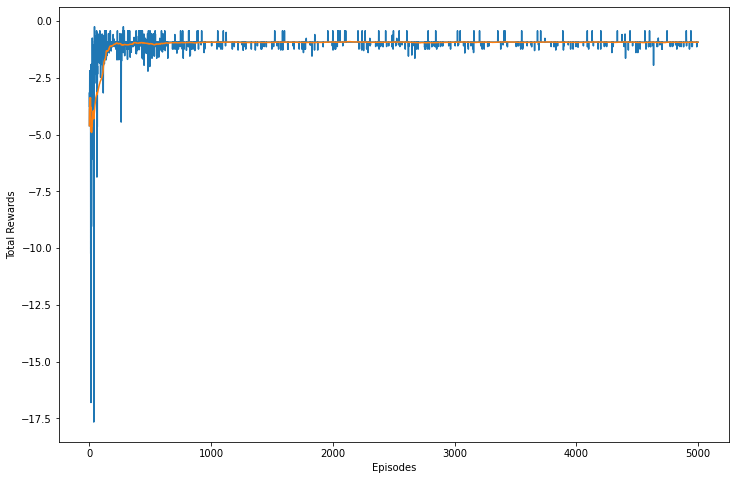

In [119]:
window = 100
smoothed_rewards = [np.mean(total_rewards[i-window:i+1]) if i > window 
                    else np.mean(total_rewards[:i+1]) for i in range(len(total_rewards))]

plt.figure(figsize=(12,8))
plt.plot(total_rewards)
plt.plot(smoothed_rewards)
#plt.plot([-11934]*1000)
#plt.plot([-8322]*1000)
#plt.plot(cum_wait_times)
#plt.plot(losses)
plt.ylabel('Total Rewards')
plt.xlabel('Episodes')
#plt.ylim(-27, 2)
plt.show()